<a href="https://colab.research.google.com/github/SelimSavas/AircraftSegmentationSAMandYOLOv8/blob/main/SAMandYOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv8 vs SAM Meta

## Library

In [1]:
!pip install ultralytics
!pip install supervision
!pip install roboflow

import numpy as np
import cv2
import os
import sys
import torch
from roboflow import Roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 16.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=b1d9da943e0bcc13caaa9f964c3fc6bc6f814c5d9bbb927377ba436044d524dc
  Stored in directory: /root/.cache/p

In [2]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
%cd {HOME}

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lh_p5a4b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lh_p5a4b
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=b8f3e364d2ad09179d4d327ec5a2711084852f11c69879b3ec3e5e7bf9c41ab8
  Stored in directory: /tmp/pip-ephem-wheel-cache-zbrzwo2r/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything


In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

## Dataset (Roboflow)

In [5]:
rf = Roboflow(api_key="Pho4XVVaJnNcR3y3HNrK")
project = rf.workspace("team12").project("airplane-bp8fl")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.81, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to airplane-2 in yolov8:: 100%|██████████| 297/297 [00:00<00:00, 1745.77it/s]


In [6]:
IMAGE_NAME = '/content/handsome-business-man-by-white-car.jpg'
IMG_SOURCE = cv2.imread(IMAGE_NAME)

In [7]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [8]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## YoloV8 - Creating BBox

In [119]:
from ultralytics import YOLO

yolo_model = YOLO('yolov8x.pt')
img = cv2.cvtColor(IMG_SOURCE, cv2.COLOR_BGR2RGB)
results = yolo_model.predict(source=img)


0: 448x640 1 person, 1 car, 1 clock, 62.2ms
Speed: 0.5ms preprocess, 62.2ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


In [130]:
k = 0
result_np_son = np.array([])
for result in results:
    result_np = np.array(result.boxes.data.cpu())

for i in result_np:
    result_np_son = np.append(result_np_son,i[:][:-2])
    k += 1

boxes = result_np_son.reshape((k,4))
boxes

array([[     434.24,      1317.1,      4881.4,      3277.1],
       [     2556.1,      656.53,      4138.3,      3326.2],
       [     4084.1,      2731.3,      4135.3,      2836.4]])

## SAM - Segmentation

In [131]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_predictor = SamPredictor(sam)

[     434.24      1317.1      4881.4      3277.1]


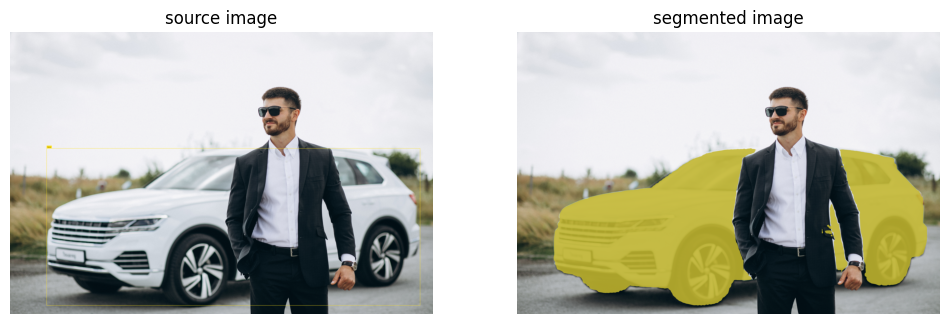

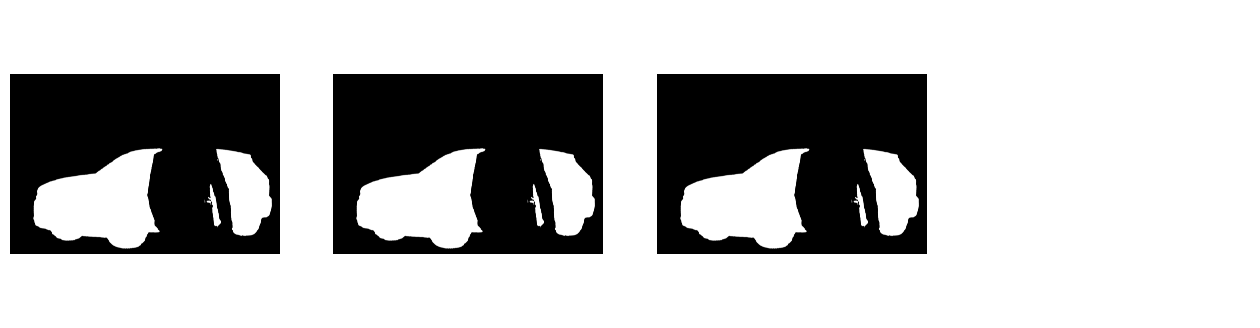

[     2556.1      656.53      4138.3      3326.2]


IndexError: ignored

In [152]:
import supervision as sv

IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

merged_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)

class_colors = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255)}


for box in boxes:
    mask_predictor.set_image(image_rgb)
    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True
    )
    print(box)

    for class_id, mask in enumerate(masks):
      merged_mask[mask] = class_id + 1
      segmented_image = np.zeros_like(image_bgr)
      segmented_image[merged_mask == class_id + 1] = class_colors[class_id]

    merged_mask = np.logical_or(merged_mask, masks)

    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=merged_mask),
        mask=merged_mask
    )

    detections = detections[detections.area == np.max(detections.area)]

    source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    sv.plot_images_grid(
        images=[source_image, segmented_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )
    sv.plot_images_grid(
      images=merged_mask,
      grid_size=(1, 4),
      size=(16, 4)
    )